In [510]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Kaggle Dataset Link: https://www.kaggle.com/datasets/mirichoi0218/insurance/data

# Data Analysis and Preprocessing

In [511]:
data = pd.read_csv("insurance.csv")

In [512]:
data.shape

(1338, 7)

In [513]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [514]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [515]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [516]:
print("Missing values in the dataset:")
data.isnull().sum()

Missing values in the dataset:


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Seperating Categorical and Numerical Columns

In [517]:
categoricals = data.select_dtypes(include=['object']).columns.tolist()
numericals = data.select_dtypes(include=['int64', 'float64']).columns.to_list()
categoricals, numericals

(['sex', 'smoker', 'region'], ['age', 'bmi', 'children', 'charges'])

### Checking for Outliers

In [518]:
data.shape
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)  # 25th percentile
        Q3 = df[col].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

### Removing Outliers

In [519]:
data = remove_outliers_iqr(data, ['age', 'children','bmi'])
data.shape

(1329, 7)

In [520]:
for each in categoricals:
    print(each, len(data[each].unique().tolist()))

sex 2
smoker 2
region 4


In [521]:
threshold = 25
data[categoricals] = data[categoricals].apply(
    lambda each: each.where(each.isin(each.value_counts().nlargest(threshold).index), "Other"))

In [522]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Encoding Categorical Columns

In [523]:
encoder = LabelEncoder()
for each in categoricals:
    data[each] = encoder.fit_transform(data[each])

In [524]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


### Splitting the Data

In [525]:
X = data.drop(columns=['charges']) 
y = data['charges'] 
numericals.remove('charges')

In [526]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Scaling the Numerical Columns

In [527]:
scaler = StandardScaler()
X_train[numericals] = scaler.fit_transform(X_train[numericals])
X_test[numericals]  = scaler.transform(X_test[numericals])

# Model Building

### Decision Tree Regressor

In [528]:
dt_model = DecisionTreeRegressor(max_depth=5, random_state=62)
dt_model.fit(X_train, y_train)
dt_pred = dt_model.predict(X_test)

### Random Forest Regressor

In [529]:
rf_model = RandomForestRegressor(n_estimators=250, max_depth=5, random_state=33)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

### Support Vector Regressor

In [530]:
svm_model = SVR(kernel='poly', C=10, gamma=10,degree=2)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)

# Model Evaluation

In [531]:
def evaluate_model(name, y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} Performance:")
    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}\n")

### Evaluating the Models

In [532]:
evaluate_model("Decision Tree", y_test, dt_pred)
evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("SVM", y_test, svm_pred)

Decision Tree Performance:
MSE: 24429759.0577, MAE: 2681.9900, R²: 0.8351

Random Forest Performance:
MSE: 20155392.5244, MAE: 2381.5949, R²: 0.8639

SVM Performance:
MSE: 25966840.1320, MAE: 2904.4499, R²: 0.8247



# Visualize Predictions

In [533]:
sorted_idx = np.argsort(y_test.values)
y_test_sorted = y_test.values[sorted_idx]
dt_pred_sorted = dt_pred[sorted_idx]
rf_pred_sorted = rf_pred[sorted_idx]
svm_pred_sorted = svm_pred[sorted_idx]

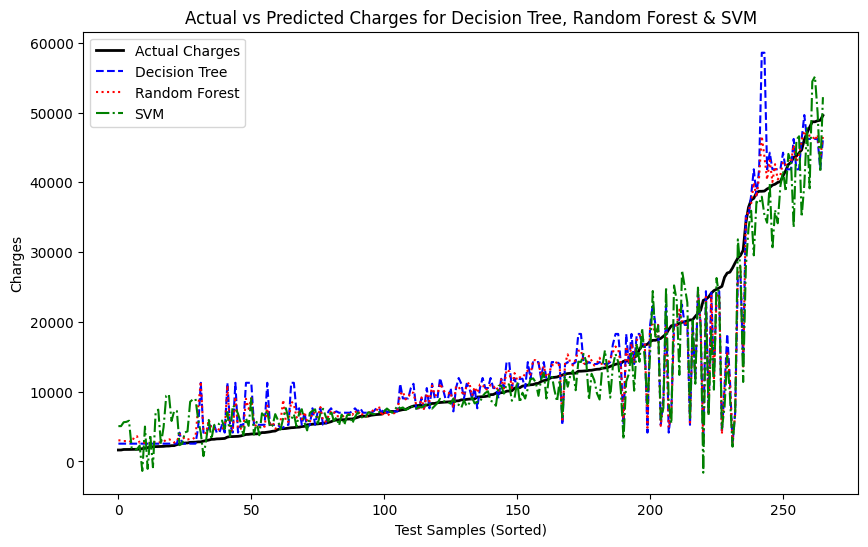

In [534]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_sorted, label="Actual Charges", color="black", linestyle="-", linewidth=2)
plt.plot(dt_pred_sorted, label="Decision Tree", color="blue", linestyle="--")
plt.plot(rf_pred_sorted, label="Random Forest", color="red", linestyle=":")
plt.plot(svm_pred_sorted, label="SVM", color="green", linestyle="-." )
plt.xlabel("Test Samples (Sorted)")
plt.ylabel("Charges")
plt.title("Actual vs Predicted Charges for Decision Tree, Random Forest & SVM")
plt.legend()
plt.show()